In [1]:
# Imports
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, make_scorer
from scipy.stats import skew
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

# Definitions
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%matplotlib inline
#njobs = 4

In [2]:
train = pd.read_csv("./train.csv")
print("train : " + str(train.shape))

train : (60000, 235)


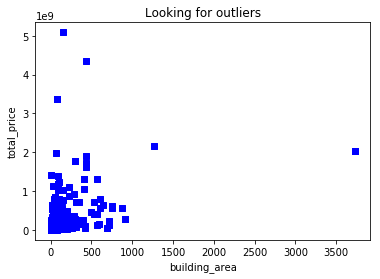

In [3]:
# Looking for outliers, as indicated in https://ww2.amstat.org/publications/jse/v19n3/decock.pdf
plt.scatter(train.building_area, train.total_price, c = "blue", marker = "s")
plt.title("Looking for outliers")
plt.xlabel("building_area")
plt.ylabel("total_price")
plt.show()

train = train[train.building_area < 1500]

In [4]:
# Log transform the target for official scoring
y = np.log1p(train.total_price)
# y = train.total_price

In [5]:
train['parking_price'] = train['parking_price'].fillna(0)
train['village_income_median'] = train['village_income_median'].fillna(train['village_income_median'].mode()[0])
train['txn_floor'] = train['txn_floor'].fillna(train['txn_floor'].mode()[0])
train.drop(['parking_area'],axis = 1, inplace=True)
for feature in train:
    if 'index' in feature:
        train.drop([feature],axis = 1, inplace = True)
        
# Change the features to categorical
train['building_material'] = train['building_material'].astype(str)
train['city'] = train['city'].astype(str)
train['town'] = train['town'].astype(str)
train['building_type'] = train['building_type'].astype(str)
train['building_use'] = train['building_use'].astype(str)
train['parking_way'] = train['parking_way'].astype(str)

print("train : " + str(train.shape))

train : (59998, 164)


In [6]:
# Find most important features relative to target
print("Find most important features relative to target")
corr = train.corr()
corr.sort_values(["total_price"], ascending = False, inplace = True)
print(corr.total_price.to_string())
with open('output.txt','w') as f:
    f.write(corr.total_price.to_string())
train.drop(['divorce_rate','death_rate','junior_rate','elementary_rate','highschool_rate'],axis = 1, inplace = True)

Find most important features relative to target
total_price                1.000
building_area              0.470
land_area                  0.291
parking_price              0.258
bachelor_rate              0.173
master_rate                0.173
doc_rate                   0.170
XIII_5000                  0.167
jobschool_rate             0.154
VII_5000                   0.145
village_income_median      0.143
V_5000                     0.141
VII_1000                   0.140
V_1000                     0.139
XIII_10000                 0.139
IX_5000                    0.138
VII_10000                  0.137
XI_10000                   0.135
V_500                      0.135
VI_10000                   0.135
IX_10000                   0.134
IX_1000                    0.134
V_10000                    0.133
VII_500                    0.132
VIII_5000                  0.131
VIII_10000                 0.129
III_10000                  0.129
X_1000                     0.128
VI_5000                    0

In [ ]:
train["XIII_5000-s2"] = train["XIII_5000"] ** 2
train["XIII_5000-s3"] = train["XIII_5000"] ** 3
train["XIII_5000-Sq"] = np.sqrt(train["XIII_5000"])
train["jobschool_rate-s2"] = train["jobschool_rate"] ** 2
train["jobschool_rate-s3"] = train["jobschool_rate"] ** 3
train["jobschool_rate-Sq"] = np.sqrt(train["jobschool_rate"])
train["bachelor_rate-s2"] = train["bachelor_rate"] ** 2
train["bachelor_rate-s3"] = train["bachelor_rate"] ** 3
train["bachelor_rate-Sq"] = np.sqrt(train["bachelor_rate"])
train["XIII_10000-s2"] = train["XIII_10000"] ** 2
train["XIII_10000-s3"] = train["XIII_10000"] ** 3
train["XIII_10000-Sq"] = np.sqrt(train["XIII_10000"])
train["VII_10000-s2"] = train["VII_10000"] ** 2
train["VII_10000-s3"] = train["VII_10000"] ** 3
train["VII_10000-Sq"] = np.sqrt(train["VII_10000"])
train["IX_10000-s2"] = train["IX_10000"] ** 2
train["IX_10000-s3"] = train["IX_10000"] ** 3
train["IX_10000-Sq"] = np.sqrt(train["IX_10000"])
print("train : " + str(train.shape))

In [ ]:
categorical_features = train.select_dtypes(include = ["object"]).columns
numerical_features = train.select_dtypes(exclude = ["object"]).columns
numerical_features = numerical_features.drop("total_price")
print("Numerical features : " + str(len(numerical_features)))
print("Categorical features : " + str(len(categorical_features)))
train_num = train[numerical_features]
train_cat = train[categorical_features]

In [ ]:
skewness = train_num.apply(lambda x: skew(x))
skewness = skewness[abs(skewness) > 1.5]
print(str(skewness.shape[0]) + " skewed numerical features to log transform")
skewed_features = skewness.index
train_num[skewed_features] = np.log1p(train_num[skewed_features])

In [ ]:
train_cat.drop(['building_id'],axis = 1, inplace = True)
train_cat = pd.get_dummies(train_cat)
print(train_cat)

In [ ]:
train = pd.concat([train_num, train_cat], axis = 1)
print("New number of features : " + str(train.shape[1]))
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size = 0.3, random_state = 0)
print("X_train : " + str(X_train.shape))
print("X_test : " + str(X_test.shape))
print("y_train : " + str(y_train.shape))
print("y_test : " + str(y_test.shape))

In [ ]:
# stdSc = StandardScaler()
# X_train.loc[:, numerical_features] = stdSc.fit_transform(X_train.loc[:, numerical_features])
# X_test.loc[:, numerical_features] = stdSc.transform(X_test.loc[:, numerical_features])


In [ ]:
# Define error measure for official scoring : RMSE
scorer = make_scorer(mean_squared_error, greater_is_better = False)

def rmse_cv_train(model):
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring = scorer, cv = 10))
    return(rmse)

def rmse_cv_test(model):
    rmse= np.sqrt(-cross_val_score(model, X_test, y_test, scoring = scorer, cv = 10))
    return(rmse)

In [ ]:
# Linear Regression
lr = LinearRegression()
lr.fit(X_train, y_train)

# Look at predictions on training and validation set
print("RMSE on Training set :", rmse_cv_train(lr).mean())
print("RMSE on Test set :", rmse_cv_test(lr).mean())
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

# Plot residuals
plt.scatter(y_train_pred, y_train_pred - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test_pred - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_pred, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_pred, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

In [ ]:
# 2* Ridge
ridge = RidgeCV(alphas = [0.01, 0.03, 0.06, 0.1, 0.3, 0.6, 1, 3, 6, 10, 30, 60])
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

print("Try again for more precision with alphas centered around " + str(alpha))
ridge = RidgeCV(alphas = [alpha * .6, alpha * .65, alpha * .7, alpha * .75, alpha * .8, alpha * .85, 
                          alpha * .9, alpha * .95, alpha, alpha * 1.05, alpha * 1.1, alpha * 1.15,
                          alpha * 1.25, alpha * 1.3, alpha * 1.35, alpha * 1.4], 
                cv = 10)
ridge.fit(X_train, y_train)
alpha = ridge.alpha_
print("Best alpha :", alpha)

print("Ridge RMSE on Training set :", rmse_cv_train(ridge).mean())
print("Ridge RMSE on Test set :", rmse_cv_test(ridge).mean())
y_train_rdg = ridge.predict(X_train)
y_test_rdg = ridge.predict(X_test)

# Plot residuals
plt.scatter(y_train_rdg, y_train_rdg - y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rdg, y_test_rdg - y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Residuals")
plt.legend(loc = "upper left")
plt.hlines(y = 0, xmin = 10.5, xmax = 13.5, color = "red")
plt.show()

# Plot predictions
plt.scatter(y_train_rdg, y_train, c = "blue", marker = "s", label = "Training data")
plt.scatter(y_test_rdg, y_test, c = "lightgreen", marker = "s", label = "Validation data")
plt.title("Linear regression with Ridge regularization")
plt.xlabel("Predicted values")
plt.ylabel("Real values")
plt.legend(loc = "upper left")
plt.plot([10.5, 13.5], [10.5, 13.5], c = "red")
plt.show()

# Plot important coefficients
coefs = pd.Series(ridge.coef_, index = X_train.columns)
print("Ridge picked " + str(sum(coefs != 0)) + " features and eliminated the other " +  \
      str(sum(coefs == 0)) + " features")
imp_coefs = pd.concat([coefs.sort_values().head(10),
                     coefs.sort_values().tail(10)])
imp_coefs.plot(kind = "barh")
plt.title("Coefficients in the Ridge Model")
plt.show()